In [449]:
!pip install gitpython
!pip install keras==2.3.1
!pip install plotly

In [450]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import os
import json
import sklearn
import sys
import pickle
import re
import requests
import git
import pandas as pd
import numpy as np
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.feature_extraction import text
from string import punctuation, printable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [451]:
path_to_json = './ai-workflow-capstone/cs-train'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files

['invoices-2018-01.json',
 'invoices-2017-12.json',
 'invoices-2019-01.json',
 'invoices-2018-11.json',
 'invoices-2018-07.json',
 'invoices-2019-06.json',
 'invoices-2019-07.json',
 'invoices-2018-06.json',
 'invoices-2018-10.json',
 'invoices-2018-09.json',
 'invoices-2019-04.json',
 'invoices-2018-05.json',
 'invoices-2018-12.json',
 'invoices-2018-04.json',
 'invoices-2019-05.json',
 'invoices-2018-08.json',
 'invoices-2019-02.json',
 'invoices-2018-03.json',
 'invoices-2017-11.json',
 'invoices-2018-02.json',
 'invoices-2019-03.json']

In [452]:
appended_data = []
for i in json_files:
    data = pd.read_json(path_to_json+'/'+i)
    data = data.rename(columns={'StreamID': 'stream_id', 'TimesViewed': 'times_viewed', 'price' : 'total_price'})
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head()

,country,customer_id,invoice,total_price,stream_id,times_viewed,year,month,day
0,United Kingdom,15581.0,493463,2.95,20895,1,2018,1,1
1,United Kingdom,15581.0,493463,1.25,20866,1,2018,1,1
2,United Kingdom,15581.0,493463,0.85,85198,12,2018,1,1
3,United Kingdom,15581.0,493463,2.95,20897,1,2018,1,1
4,United Kingdom,15581.0,493463,2.95,20898,1,2018,1,1


In [453]:
appended_data["date"] = appended_data["day"].astype(str) + '-' + appended_data["month"].astype(str) + '-' + appended_data["year"].astype(str)
appended_data['invoice'] = appended_data['invoice'].str.replace(r'\D', '').astype(int)
appended_data['date']= pd.to_datetime(appended_data['date'])
appended_data.head()

,country,customer_id,invoice,total_price,stream_id,times_viewed,year,month,day,date
0,United Kingdom,15581.0,493463,2.95,20895,1,2018,1,1,2018-01-01
1,United Kingdom,15581.0,493463,1.25,20866,1,2018,1,1,2018-01-01
2,United Kingdom,15581.0,493463,0.85,85198,12,2018,1,1,2018-01-01
3,United Kingdom,15581.0,493463,2.95,20897,1,2018,1,1,2018-01-01
4,United Kingdom,15581.0,493463,2.95,20898,1,2018,1,1,2018-01-01


In [454]:
appended_data.describe()

,customer_id,invoice,total_price,times_viewed,year,month,day
count,625249.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000,815011.000000
mean,15333.415068,526773.221948,4.802631,5.231106,2018.247654,6.592718,15.064819
std,1698.360788,20734.819988,135.058707,5.109982,0.545261,3.598781,8.788845
min,12346.000000,489434.000000,-53594.360000,0.000000,2017.000000,1.000000,1.000000
25%,13956.000000,509031.000000,1.250000,1.000000,2018.000000,3.000000,7.000000
50%,15279.000000,528383.000000,2.100000,3.000000,2018.000000,6.000000,15.000000
75%,16813.000000,543527.000000,4.210000,8.000000,2019.000000,10.000000,23.000000
max,18287.000000,562271.000000,38970.000000,24.000000,2019.000000,12.000000,31.000000


In [455]:
print("Unique values stream_id =",  appended_data['stream_id'].nunique())
print("Unique values country =",  appended_data['country'].nunique())
print("Unique values customer_id =",  appended_data['customer_id'].nunique())
print("Unique values invoice =",  appended_data['invoice'].nunique())

Unique values stream_id = 5007
Unique values country = 43
Unique values customer_id = 5225
Unique values invoice = 42646


In [456]:
Top10countries = appended_data.groupby(by=["country"]).sum()
Top10countries = Top10countries.sort_values(by=['total_price'], ascending=False)
Top10countries = Top10countries.drop(columns=['customer_id', 'invoice', 'year', 'month', 'day'])
Top10countries.head(12)

,total_price,times_viewed
country,,
United Kingdom,3.521514e+06,3725703
EIRE,1.070692e+05,111636
Germany,4.927182e+04,112618
France,4.056514e+04,83124
Norway,3.849475e+04,7881
Spain,1.604099e+04,19573
Hong Kong,1.445257e+04,2635
Portugal,1.352867e+04,14195
Singapore,1.317592e+04,3042


In [457]:
n = 10
notintop10 = Top10countries.index.values.tolist()
del notintop10[:n]
print(notintop10)

['Belgium', 'Switzerland', 'Sweden', 'Channel Islands', 'Australia', 'Malta', 'Italy', 'Cyprus', 'Austria', 'Finland', 'RSA', 'Unspecified', 'Greece', 'United Arab Emirates', 'Denmark', 'Poland', 'USA', 'Japan', 'Canada', 'Iceland', 'Lithuania', 'Israel', 'Bahrain', 'Lebanon', 'European Community', 'Brazil', 'Thailand', 'Korea', 'West Indies', 'Nigeria', 'Bermuda', 'Czech Republic', 'Saudi Arabia']


In [458]:
appended_data_top10 = appended_data
for c in notintop10:
    indexNames = appended_data_top10[(appended_data_top10['country'] == c)].index
    appended_data_top10.drop(indexNames , inplace=True)
appended_data_top10

,country,customer_id,invoice,total_price,stream_id,times_viewed,year,month,day,date
0,United Kingdom,15581.0,493463,2.95,20895,1,2018,1,1,2018-01-01
1,United Kingdom,15581.0,493463,1.25,20866,1,2018,1,1,2018-01-01
2,United Kingdom,15581.0,493463,0.85,85198,12,2018,1,1,2018-01-01
3,United Kingdom,15581.0,493463,2.95,20897,1,2018,1,1,2018-01-01
4,United Kingdom,15581.0,493463,2.95,20898,1,2018,1,1,2018-01-01
...,...,...,...,...,...,...,...,...,...,...
35050,United Kingdom,13269.0,548708,4.95,23184,2,2019,3,31,2019-03-31
35051,United Kingdom,13269.0,548708,1.25,47310M,1,2019,3,31,2019-03-31
35052,United Kingdom,13269.0,548708,0.42,79190B,9,2019,3,31,2019-03-31
35053,United Kingdom,13269.0,548708,1.65,22859,1,2019,3,31,2019-03-31


In [459]:
print("Unique values stream_id =",  appended_data['stream_id'].nunique())
print("Unique values country =",  appended_data['country'].nunique())
print("Unique values customer_id =",  appended_data['customer_id'].nunique())
print("Unique values invoice =",  appended_data['invoice'].nunique())

appended_data.country.unique()

Unique values stream_id = 4872
Unique values country = 10
Unique values customer_id = 4902
Unique values invoice = 36246


array(['United Kingdom', 'Germany', 'EIRE', 'France', 'Spain',
       'Netherlands', 'Portugal', 'Norway', 'Hong Kong', 'Singapore'],
      dtype=object)

In [460]:
grouped_data = appended_data_top10.groupby(by=['country', 'date', 'year', 'month', 'day']).sum()
grouped_data = grouped_data.drop(columns=['invoice', 'customer_id'])
grouped_data.reset_index(inplace=True)
grouped_data.head(10)

,country,date,year,month,day,total_price,times_viewed
0,EIRE,2017-04-12,2017,12,4,181.65,86
1,EIRE,2017-05-12,2017,12,5,87.40,244
2,EIRE,2017-07-12,2017,12,7,25.22,28
3,EIRE,2017-08-12,2017,12,8,20.90,7
4,EIRE,2017-10-12,2017,12,10,2.74,21
5,EIRE,2017-11-12,2017,12,11,17.70,7
6,EIRE,2017-11-28,2017,11,28,331.19,464
7,EIRE,2017-11-30,2017,11,30,147.02,143
8,EIRE,2017-12-12,2017,12,12,289.46,418
9,EIRE,2017-12-13,2017,12,13,104.41,212


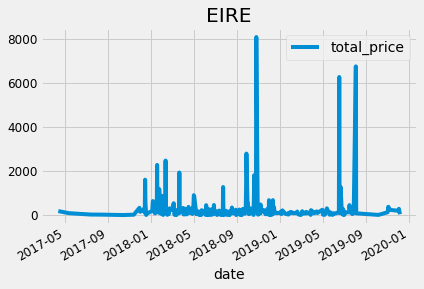

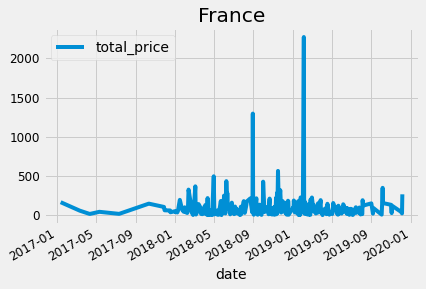

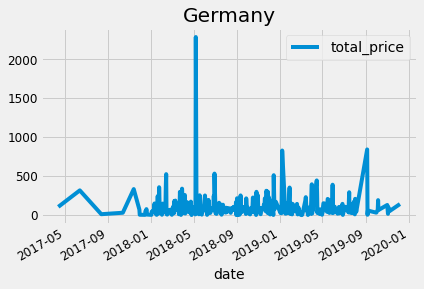

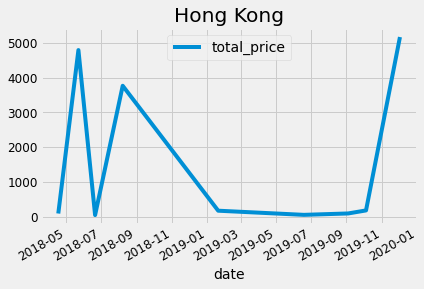

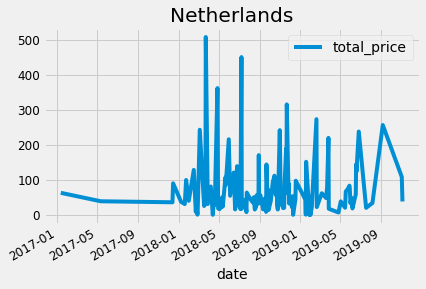

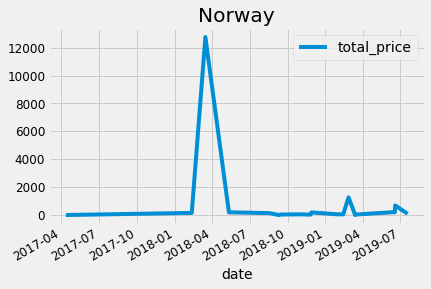

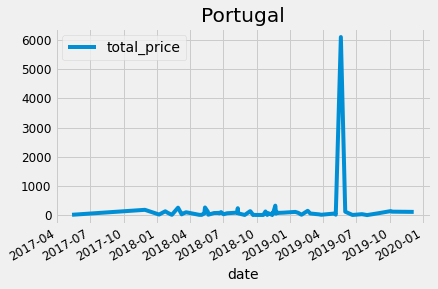

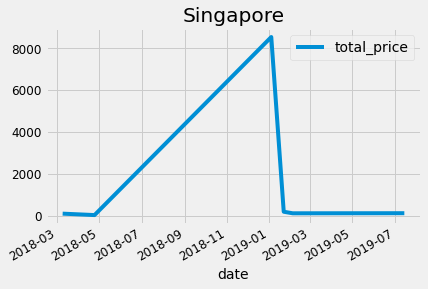

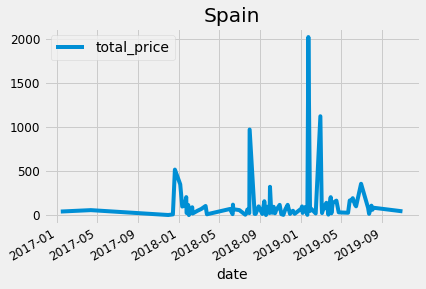

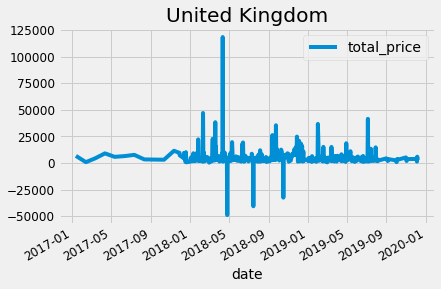

In [461]:
for country in grouped_data['country'].unique():
     grouped_data[grouped_data['country']==country].sort_values('date').plot.line(x='date',
                                                              y='total_price',
                                                              title=country)

In [462]:
grouped = grouped_data.groupby(grouped_data.country) 
df_UK = grouped.get_group("United Kingdom") 
df_EIRE = grouped.get_group("EIRE")
df_Germany = grouped.get_group("Germany")
df_France = grouped.get_group("France")
df_Spain = grouped.get_group("Spain")
df_NL = grouped.get_group("Netherlands")
df_Portugal = grouped.get_group("Portugal")
df_Norway = grouped.get_group("Norway")
df_HK = grouped.get_group("Hong Kong")
df_Singh = grouped.get_group("Singapore")

In [463]:
df_UK["yearmonth"] = df_UK["month"].astype(str) + '-' + df_UK["year"].astype(str)
df_UK['yearmonth']= pd.to_datetime(df_UK['yearmonth'])
df_UK = df_UK.groupby(by=["yearmonth"]).sum()

df_EIRE["yearmonth"] = df_EIRE["month"].astype(str) + '-' + df_EIRE["year"].astype(str)
df_EIRE['yearmonth']= pd.to_datetime(df_EIRE['yearmonth'])
df_EIRE = df_EIRE.groupby(by=["yearmonth"]).sum()

df_Germany["yearmonth"] = df_Germany["month"].astype(str) + '-' + df_Germany["year"].astype(str)
df_Germany['yearmonth']= pd.to_datetime(df_Germany['yearmonth'])
df_Germany = df_Germany.groupby(by=["yearmonth"]).sum()

df_France["yearmonth"] = df_France["month"].astype(str) + '-' + df_France["year"].astype(str)
df_France['yearmonth']= pd.to_datetime(df_France['yearmonth'])
df_France = df_France.groupby(by=["yearmonth"]).sum()

df_Spain["yearmonth"] = df_Spain["month"].astype(str) + '-' + df_Spain["year"].astype(str)
df_Spain['yearmonth']= pd.to_datetime(df_Spain['yearmonth'])
df_Spain = df_Spain.groupby(by=["yearmonth"]).sum()

df_NL["yearmonth"] = df_NL["month"].astype(str) + '-' + df_NL["year"].astype(str)
df_NL['yearmonth']= pd.to_datetime(df_NL['yearmonth'])
df_NL = df_NL.groupby(by=["yearmonth"]).sum()

df_Portugal["yearmonth"] = df_Portugal["month"].astype(str) + '-' + df_Portugal["year"].astype(str)
df_Portugal['yearmonth']= pd.to_datetime(df_Portugal['yearmonth'])
df_Portugal = df_Portugal.groupby(by=["yearmonth"]).sum()

df_Norway["yearmonth"] = df_Norway["month"].astype(str) + '-' + df_Norway["year"].astype(str)
df_Norway['yearmonth']= pd.to_datetime(df_Norway['yearmonth'])
df_Norway = df_Norway.groupby(by=["yearmonth"]).sum()

df_HK["yearmonth"] = df_HK["month"].astype(str) + '-' + df_HK["year"].astype(str)
df_HK['yearmonth']= pd.to_datetime(df_HK['yearmonth'])
df_HK = df_HK.groupby(by=["yearmonth"]).sum()

df_Singh["yearmonth"] = df_Singh["month"].astype(str) + '-' + df_Singh["year"].astype(str)
df_Singh['yearmonth']= pd.to_datetime(df_Singh['yearmonth'])
df_Singh = df_Singh.groupby(by=["yearmonth"]).sum()

In [464]:
df_UK.reset_index(inplace=True)
df_UK

,yearmonth,year,month,day,total_price,times_viewed
0,2017-11-01,6051,33,87,26481.670,27017
1,2017-12-01,36306,216,185,98676.460,100658
2,2018-01-01,54486,27,430,113260.833,104815
3,2018-02-01,48432,48,352,70857.423,90806
4,2018-03-01,50450,75,381,151148.880,125876
5,2018-04-01,46414,92,362,50790.951,108181
6,2018-05-01,52468,130,406,94548.730,123255
7,2018-06-01,50450,150,385,124397.410,122660
8,2018-07-01,54486,189,426,42404.180,111926
9,2018-08-01,52468,208,411,79503.480,111302


MODELING

In [465]:
df_UK = df_UK.set_index('yearmonth')
df_UK.index

DatetimeIndex(['2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01'],
              dtype='datetime64[ns]', name='yearmonth', freq=None)

In [466]:
df_UK.isnull().sum()

year            0
month           0
day             0
total_price     0
times_viewed    0
dtype: int64

In [467]:
y = df_UK['total_price'].resample('MS').mean()
y['2017':]

yearmonth
2017-11-01     26481.670
2017-12-01     98676.460
2018-01-01    113260.833
2018-02-01     70857.423
2018-03-01    151148.880
2018-04-01     50790.951
2018-05-01     94548.730
2018-06-01    124397.410
2018-07-01     42404.180
2018-08-01     79503.480
2018-09-01    158486.350
2018-10-01    181648.110
2018-11-01    268474.381
2018-12-01    259933.490
2019-01-01    128178.380
2019-02-01     84068.580
2019-03-01     94234.350
2019-04-01     85861.220
2019-05-01    105849.590
2019-06-01    126905.060
2019-07-01    114602.130
Freq: MS, Name: total_price, dtype: float64

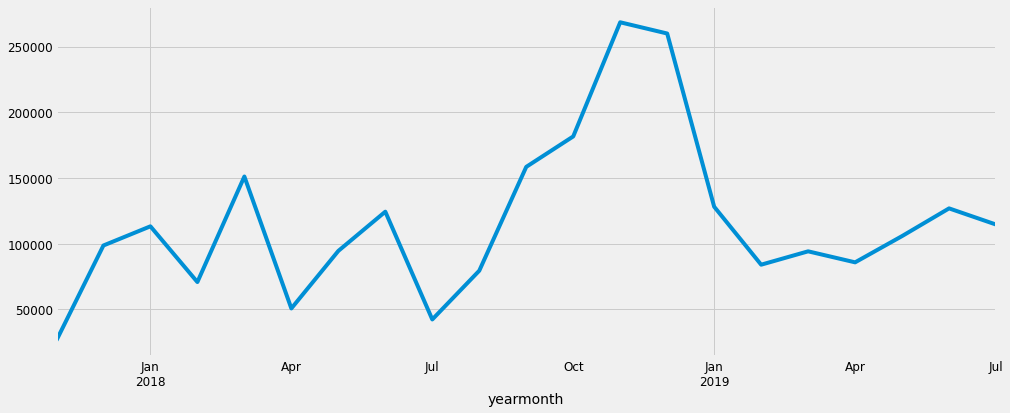

In [468]:
y.plot(figsize=(15, 6))
plt.show()

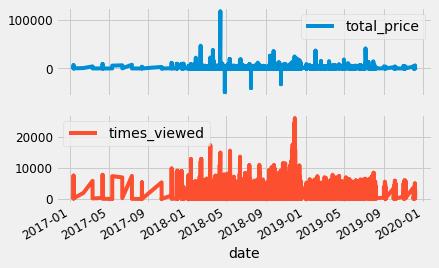

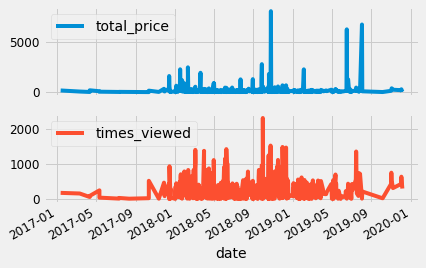

In [469]:
grouped_datax = pd.get_dummies(grouped_data, columns=['country'], drop_first=True, prefix='country')
date_time = pd.to_datetime(grouped_datax.pop('date'), format='%d.%m.%Y %H:%M:%S')
plot_cols = ['total_price', 'times_viewed']
plot_features = grouped_datax[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = grouped_datax[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)



In [470]:
column_indices = {name: i for i, name in enumerate(grouped_datax.columns)}

n = len(grouped_datax)
train_df = grouped_datax[0:int(n*0.7)]
val_df = grouped_datax[int(n*0.7):int(n*0.9)]
test_df = grouped_datax[int(n*0.9):]

num_features = grouped_datax.shape[1]

In [471]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

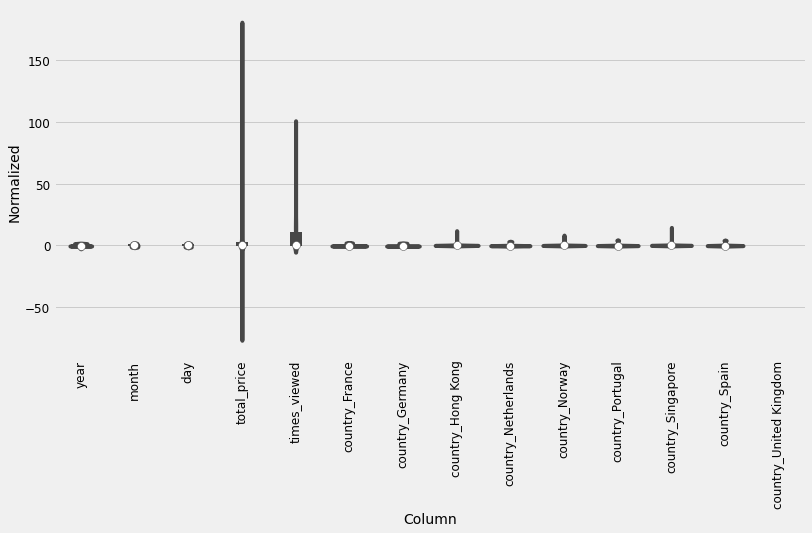

In [472]:
import seaborn as sns
df_std = (grouped_datax - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(grouped_datax.keys(), rotation=90)

In [473]:
grouped_datax.tail()

,year,month,day,total_price,times_viewed,country_France,country_Germany,country_Hong Kong,country_Netherlands,country_Norway,country_Portugal,country_Singapore,country_Spain,country_United Kingdom
1714,2019,3,12,3211.89,3335,0,0,0,0,0,0,0,0,1
1715,2019,4,12,4765.38,3700,0,0,0,0,0,0,0,0,1
1716,2019,5,12,1375.65,2075,0,0,0,0,0,0,0,0,1
1717,2019,6,12,5957.74,5001,0,0,0,0,0,0,0,0,1
1718,2019,7,12,2736.96,2779,0,0,0,0,0,0,0,0,1


In [474]:
dataset_target = grouped_datax['total_price']
dataset_data = grouped_datax

X_train, X_test, y_train, y_test = train_test_split(dataset_data, dataset_target, test_size=0.2,  random_state=2)

## LSTM Model UK

In [475]:
df_UK = df_UK.drop(columns=['year', 'month', 'day'])
df_UK.reset_index(inplace=True)
df_diff_UK = df_UK.copy()
df_diff_UK['prev_sales'] = df_diff_UK['total_price'].shift(1)
#drop the null values and calculate the difference
df_diff_UK = df_diff_UK.dropna()
df_diff_UK['diff'] = (df_diff_UK['total_price'] - df_diff_UK['prev_sales'])
#create dataframe for transformation from time series to supervised
df_supervised_UK = df_diff_UK.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised_UK[field_name] = df_supervised_UK['diff'].shift(inc)
#drop null values
df_supervised_UK = df_supervised_UK.dropna().reset_index(drop=True)

# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
df_supervised.drop(columns=['lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12'])
print(regression_adj_rsq)

0.9870618398025727


In [476]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['total_price','yearmonth'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values



In [477]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [478]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [479]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
2/2 [==============================] - 0s 227ms/step - loss: 1.3207
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1790
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1281
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 1.1030
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0866
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0737
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0623
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0517
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0416
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0322
Epoch 11/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0234
Epoch 12/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0151
Epoch 13/100
2/2 [==============================] - 0s 3ms/

In [480]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

In [481]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[ -0.22507945   0.42264928  -3.58399676  -1.99592852   1.28101917
   -1.66553735   1.70337863   1.12965837 -17.08183391   0.80697317
    0.59552945  -1.94469346   3.30600597  -2.97838467]]
[[ 0.70292532  1.30364452 -1.7459362  -5.86666331 -2.13586602  1.37453355
   0.76593763  1.87863646  0.0425722  -0.74513952  0.44153946  0.40447911
  -3.03392783  1.28108344]]
[[-0.29262331  1.00272308 -0.60769178 -3.11331428 -6.55047615 -3.17938399
   1.83509807  0.88042193  6.06504282  0.90759537 -0.7966813   0.17775245
   2.02384773 -4.9903305 ]]
[[-0.08791491  1.46308391 -0.99648179 -1.40826482 -3.41025519 -9.06303808
   0.23353394  2.01889517 -1.96151735  1.48884457  0.5218123  -1.64533784
   1.53570454  0.01278232]]
[[ 0.45753309  1.48040496 -0.40169634 -1.99065836 -1.46562994 -4.87784995
  -1.83568432  0.31350294  7.19285146  0.71417385  0.98551241  0.29594191
  -2.38941429 -0.47008518]]
[[-0.10507645  0.93893499 -0.37931757 -1.09969102 -2.12985535 -2.28611434
  -0.36379838 -1.88986105 -6.520

In [482]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_UK[-7:].yearmonth)
act_sales = list(df_UK[-7:].total_price)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['yearmonth'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales

In [483]:
df_result

,pred_value,yearmonth
0,251877,2019-02-01
1,221670,2019-03-01
2,216921,2019-04-01
3,211615,2019-05-01
4,239775,2019-06-01
5,252401,2019-07-01


In [484]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_UK,df_result,on='yearmonth',how='left')
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['yearmonth'],
        y=df_sales_pred['total_price'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['yearmonth'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)